In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib

In [4]:
df = pd.read_csv('flattened_street_dataset.csv') 

In [5]:
X = df.iloc[:, :-1].values  # All columns except last
y = df.iloc[:, -1].values   # Last column (labels)

In [6]:
print(f"Number of good streets (0): {sum(y==0)}")
print(f"Number of streets with holes (1): {sum(y==1)}")

Number of good streets (0): 10531
Number of streets with holes (1): 7628


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

GaussianNB()

In [9]:
y_pred = nb_model.predict(X_test_scaled)
y_pred_proba = nb_model.predict_proba(X_test_scaled)[:, 1]

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nNaive Bayes Accuracy: {accuracy:.4f}")

# Print detailed results
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Good Street', 'Street with Holes']))


Naive Bayes Accuracy: 0.7907

Classification Report:
                   precision    recall  f1-score   support

      Good Street       0.83      0.82      0.82      2142
Street with Holes       0.74      0.75      0.75      1490

         accuracy                           0.79      3632
        macro avg       0.78      0.78      0.78      3632
     weighted avg       0.79      0.79      0.79      3632



Text(158.22222222222223, 0.5, 'Actual')

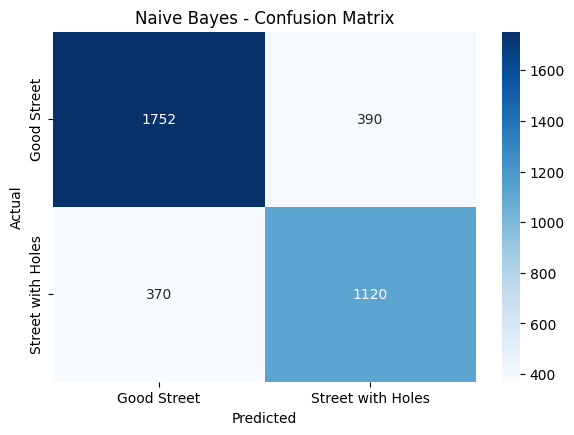

In [12]:
plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good Street', 'Street with Holes'],
            yticklabels=['Good Street', 'Street with Holes'])
plt.title('Naive Bayes - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

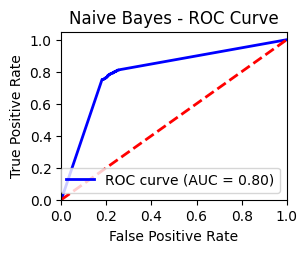

In [13]:
# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - ROC Curve')
plt.legend(loc="lower right")

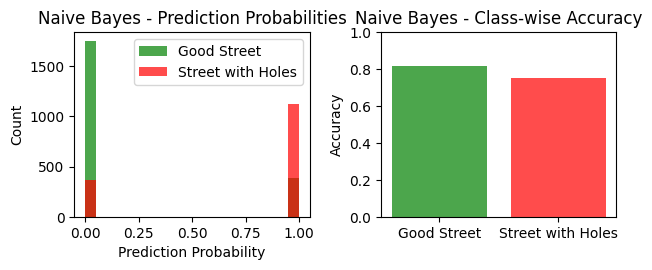

In [14]:
# 3. Prediction Probability Distribution
plt.subplot(2, 2, 3)
plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Good Street', color='green')
plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Street with Holes', color='red')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Naive Bayes - Prediction Probabilities')
plt.legend()

# 4. Accuracy Bar Chart
plt.subplot(2, 2, 4)
classes = ['Good Street', 'Street with Holes']
class_accuracies = [cm[0,0]/(cm[0,0]+cm[0,1]), cm[1,1]/(cm[1,1]+cm[1,0])]
plt.bar(classes, class_accuracies, color=['green', 'red'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Naive Bayes - Class-wise Accuracy')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

In [15]:
joblib.dump({'model': nb_model, 'scaler': scaler}, 'naive_bayes_model.pkl')
print("\nModel saved as 'naive_bayes_model.pkl'")


Model saved as 'naive_bayes_model.pkl'



--- Prediction for C:\Users\mousa\Downloads\street-hole-dangerous-missing-manhole-46085691.webp ---
Predicted: Street with Holes
Probability of being a 'Street with Holes': 1.0000


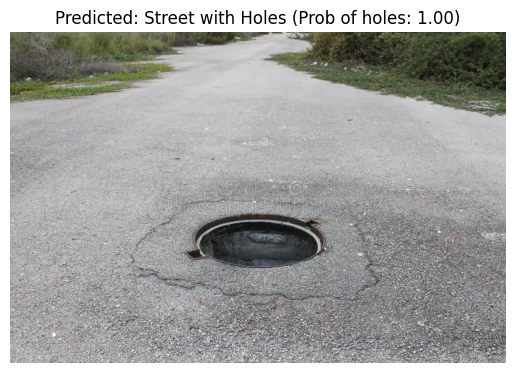

In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def test_single_image(image_path, model, scaler, image_size=(64, 64)):
    try:
        # Load and resize the image
        img = Image.open(image_path).convert('RGB').resize(image_size)

        # Convert to numpy array and normalize pixel values
        img_array = np.array(img) / 255.0

        # Flatten the image (same as how the CSV was created)
        img_flat = img_array.flatten()

        # Reshape for the scaler (scaler expects a 2D array: [n_samples, n_features])
        img_flat_reshaped = img_flat.reshape(1, -1)

        # Scale the image using the *fitted* scaler
        img_scaled = scaler.transform(img_flat_reshaped)

        # Make a prediction
        prediction = model.predict(img_scaled)[0]
        prediction_proba = model.predict_proba(img_scaled)[:, 1][0] # Probability of class 1

        return prediction, prediction_proba

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

# Test your image here
test_image_path = r"C:\Users\mousa\Downloads\street-hole-dangerous-missing-manhole-46085691.webp" 

predicted_label, probability_of_holes = test_single_image(test_image_path, nb_model, scaler)

if predicted_label is not None:
    print(f"\n--- Prediction for {test_image_path} ---")
    if predicted_label == 0:
        print("Predicted: Good Street")
    else:
        print("Predicted: Street with Holes")
    print(f"Probability of being a 'Street with Holes': {probability_of_holes:.4f}")

    img_display = Image.open(test_image_path)
    plt.imshow(img_display)
    plt.title(f"Predicted: {'Street with Holes' if predicted_label == 1 else 'Good Street'} (Prob of holes: {probability_of_holes:.2f})")
    plt.axis('off')
    plt.show()

In [ ]:

print(f"Model accuracy is: {accuracy:.4f}")


Model accuracy is: 0.7907
